# Analisis de 6 emociones

Lucho Sep|2024 <br>
Tout Doucement by Feist

Este dataset, es una series de frases o palabras la cual se clasifica en base a las emociones.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, LSTM,Dropout, Bidirectional, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import pickle
import re
import warnings

# Ignorar todos los warnings
warnings.filterwarnings('ignore')

## Import dataset

In [2]:
df = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
train_raw = df.copy()
df['length'] = [len(x) for x in df['Comment']]
df.head()

Comment  Emotion  length
0                            i didnt feel humiliated  sadness      23
1  i can go from feeling so hopeless to so damned...  sadness     108
2   im grabbing a minute to post i feel greedy wrong    anger      48
3  i am ever feeling nostalgic about the fireplac...     love      92
4                               i am feeling grouchy    anger      20

In [3]:
df.shape

(16000, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  16000 non-null  object
 1   Emotion  16000 non-null  object
 2   length   16000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [5]:
df.describe(include="all").T

count unique                                                top  \
Comment    16000  15969  i feel on the verge of tears from weariness i ...   
Emotion    16000      6                                                joy   
length   16000.0    NaN                                                NaN   

         freq       mean        std  min   25%   50%    75%    max  
Comment     2        NaN        NaN  NaN   NaN   NaN    NaN    NaN  
Emotion  5362        NaN        NaN  NaN   NaN   NaN    NaN    NaN  
length    NaN  96.845812  55.904953  7.0  53.0  86.0  129.0  300.0

In [6]:
df.isna().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [7]:
df.duplicated().sum()

1

In [8]:
df = df.drop_duplicates()
df.head()

Comment  Emotion  length
0                            i didnt feel humiliated  sadness      23
1  i can go from feeling so hopeless to so damned...  sadness     108
2   im grabbing a minute to post i feel greedy wrong    anger      48
3  i am ever feeling nostalgic about the fireplac...     love      92
4                               i am feeling grouchy    anger      20

### EDA

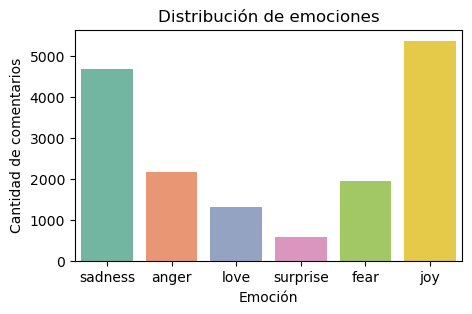

In [9]:
# 1. üìä Distribuci√≥n de emociones
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Emotion', palette='Set2')
plt.title('Distribuci√≥n de emociones')
plt.xlabel('Emoci√≥n')
plt.ylabel('Cantidad de comentarios')
plt.show()

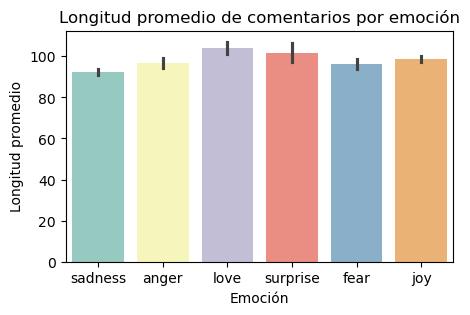

In [10]:
# 2. üìè Longitud promedio por emoci√≥n
plt.figure(figsize=(5, 3))
sns.barplot(data=df, x='Emotion', y='length', palette='Set3', estimator='mean')
plt.title('Longitud promedio de comentarios por emoci√≥n')
plt.xlabel('Emoci√≥n')
plt.ylabel('Longitud promedio')
plt.show()

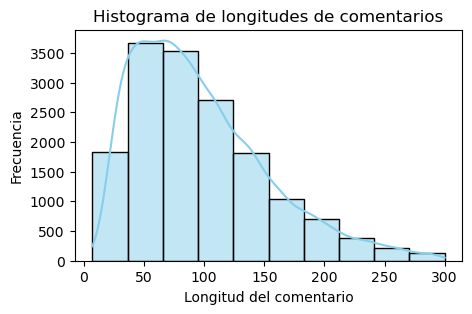

In [11]:
# 3. üìà Histograma de longitudes de comentarios
plt.figure(figsize=(5, 3))
sns.histplot(df['length'], bins=10, kde=True, color='skyblue')
plt.title('Histograma de longitudes de comentarios')
plt.xlabel('Longitud del comentario')
plt.ylabel('Frecuencia')
plt.show()

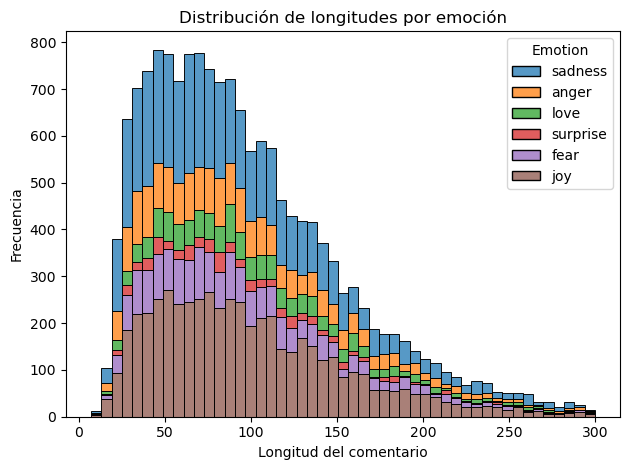

In [12]:
#Distribucion de los datos
df2 = df.copy()
df2['length'] = df2['Comment'].apply(len)

# Histograma apilado por emoci√≥n
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.title('Distribuci√≥n de longitudes por emoci√≥n')
plt.xlabel('Longitud del comentario')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


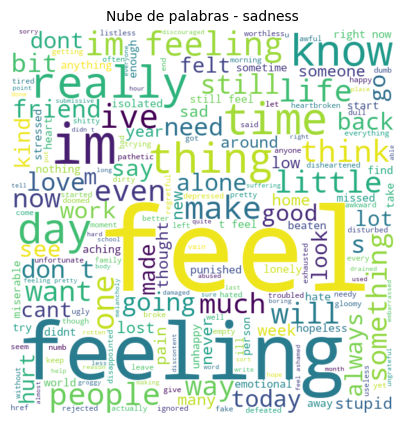

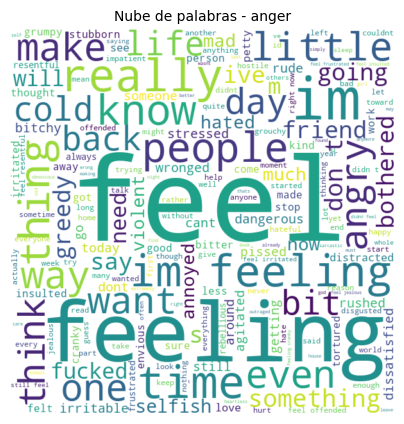

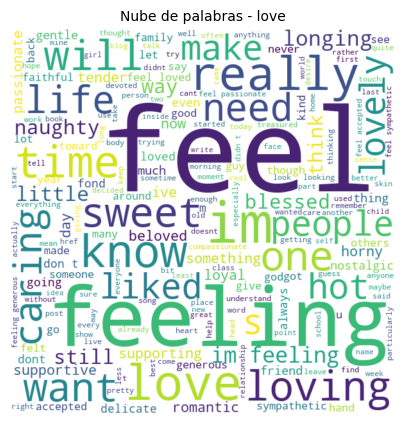

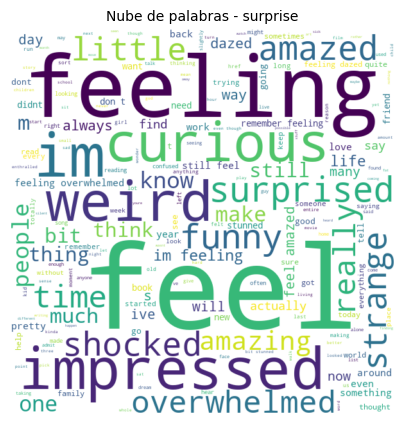

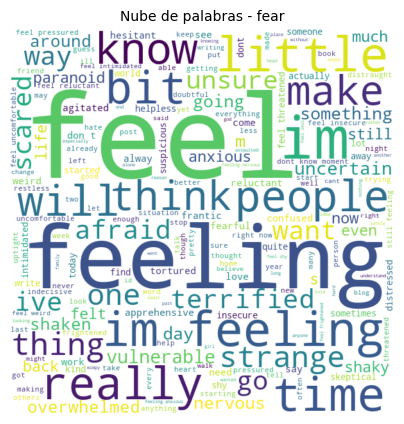

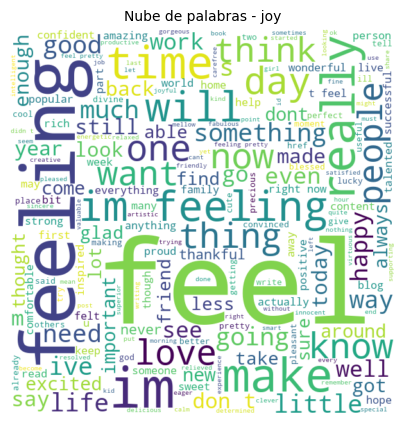

In [13]:
# Funci√≥n para mostrar la nube de palabras
def nube_palabras(wordcloud, emocion):
    plt.figure(figsize=(5, 5))
    plt.title(f'Nube de palabras - {emocion}', size=10)
    plt.imshow(wordcloud, interpolation='bilinear')  # Mostrar imagen suavizada
    plt.axis("off")  # No mostrar ejes

# Obtener la lista de emociones √∫nicas
lista_emociones = df['Emotion'].unique()

# Generar y mostrar una nube de palabras para cada emoci√≥n
for emocion in lista_emociones:
    # Concatenar todos los comentarios que tengan esa emoci√≥n en un solo texto
    texto = ' '.join(df.loc[df['Emotion'] == emocion, 'Comment'])
    
    # Crear la nube de palabras con dimensiones definidas
    wordcloud = WordCloud(width=600, height=600, background_color='white').generate(texto)
    
    # Mostrar la nube de palabras usando la funci√≥n definida
    nube_palabras(wordcloud, emocion)

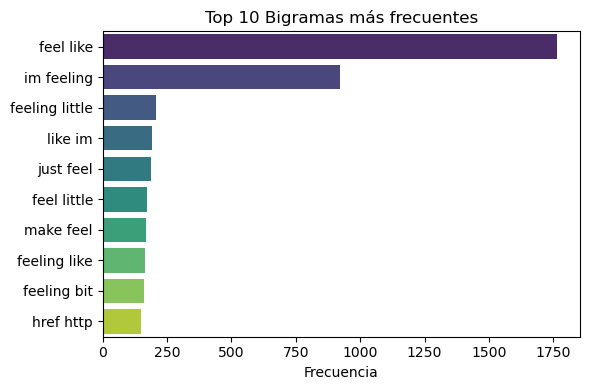

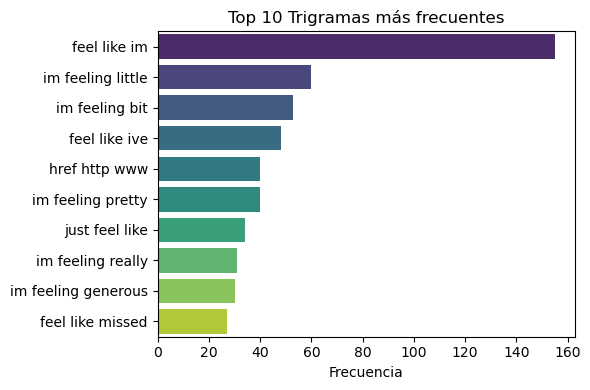

In [14]:
#Pasar a strings por las dudas
comentarios = df['Comment'].astype(str) 

def plot_top_ngrams(comments, ngram_range=(2,2), top_n=10, title=''):
    # Crear un vectorizador para n-gramas (bigramas o trigramas)
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')  # pod√©s cambiar stop_words a espa√±ol si quer√©s
    
    # Ajustar y transformar los comentarios
    X = vectorizer.fit_transform(comments)
    
    # Sumar la frecuencia de cada n-grama
    suma_ngrams = X.sum(axis=0)
    
    # Mapear n-gramas con sus frecuencias
    ngrams_freq = [(ngram, suma_ngrams[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    
    # Ordenar por frecuencia descendente
    ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Convertir a DataFrame para graficar
    df_ngrams = pd.DataFrame(ngrams_freq, columns=['N-grama', 'Frecuencia'])
    
    # Graficar
    plt.figure(figsize=(6,4))
    sns.barplot(data=df_ngrams, y='N-grama', x='Frecuencia', palette='viridis')
    plt.title(title)
    plt.xlabel('Frecuencia')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Graficar los 10 bigramas m√°s comunes
plot_top_ngrams(comentarios, ngram_range=(2,2), top_n=10, title='Top 10 Bigramas m√°s frecuentes')

# Graficar los 10 trigramas m√°s comunes
plot_top_ngrams(comentarios, ngram_range=(3,3), top_n=10, title='Top 10 Trigramas m√°s frecuentes')

### Procesamiento de datos & entrenamiento

In [15]:
lb = LabelEncoder()
df['Emotion'] = lb.fit_transform(df['Emotion'])
df.head()

Comment  Emotion  length
0                            i didnt feel humiliated        4      23
1  i can go from feeling so hopeless to so damned...        4     108
2   im grabbing a minute to post i feel greedy wrong        0      48
3  i am ever feeling nostalgic about the fireplac...        3      92
4                               i am feeling grouchy        0      20

In [16]:
# Crear un conjunto con las stopwords en ingl√©s
stopwords = set(nltk.corpus.stopwords.words('english'))

# Funci√≥n para limpiar el texto
def limpiar_texto(texto):
    stemmer = PorterStemmer()  # Inicializar el stemmer (ra√≠z de palabras)
    texto = re.sub("[^a-zA-Z]", " ", texto)  # Remover todo lo que no sea letra
    texto = texto.lower()  # Pasar todo a min√∫sculas
    texto = texto.split()  # Separar en palabras (tokens)
    # Eliminar stopwords y aplicar stemming a cada palabra
    texto = [stemmer.stem(palabra) for palabra in texto if palabra not in stopwords]
    return " ".join(texto)  # Volver a unir las palabras en un string

# Aplicar la funci√≥n a la columna 'Comment' y guardar el resultado en una nueva columna
df['comentario_limpio'] = df['Comment'].apply(limpiar_texto)

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['comentario_limpio'],df['Emotion'],test_size=0.2,random_state=42)

In [18]:
# Vectorization usando TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [19]:
# Clasificaci√≥n multiclase usando diferentes algoritmos
classificadores = {
    "Naive Bayes Multinomial": MultinomialNB(),
    "Regresi√≥n Log√≠stica": LogisticRegression(),
    "Bosque Aleatorio (Random Forest)": RandomForestClassifier(),
    "M√°quina de Vectores de Soporte (SVM)": SVC(),
}


===== Naive Bayes Multinomial =====
Precisi√≥n usando TF-IDF: 0.6590625
Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.95      0.32      0.48       439
           1       0.88      0.23      0.37       375
           2       0.58      0.98      0.73      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200


===== Regresi√≥n Log√≠stica =====
Precisi√≥n usando TF-IDF: 0.825
Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       439
           1       0.85      0.72      0.78       375
           2       0.76      0.94      0.84      1027
           3       0.84      0.47      0.60   

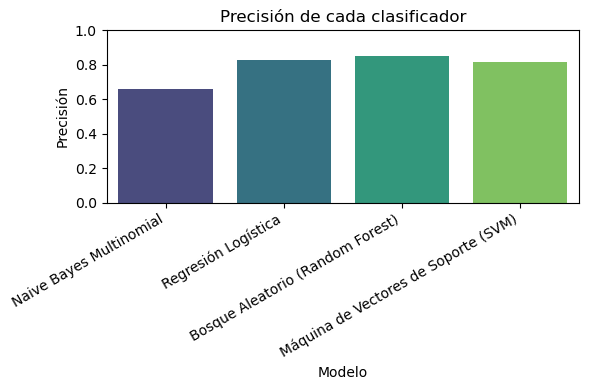

In [20]:
# Guardar los modelos y sus precisiones
resultados = []

for nombre, modelo in classificadores.items():
    modelo.fit(X_train_tfidf, y_train)
    y_pred = modelo.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    
    resultados.append((nombre, acc))
    print(f"\n===== {nombre} =====")
    print(f"Precisi√≥n usando TF-IDF: {acc}")
    print("Reporte de clasificaci√≥n:")
    print(classification_report(y_test, y_pred))

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados, columns=['Modelo', 'Precisi√≥n'])

# Graficar
plt.figure(figsize=(6, 4))  
sns.barplot(data=df_resultados, x='Modelo', y='Precisi√≥n', palette='viridis')
plt.title('Precisi√≥n de cada clasificador', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.ylabel('Precisi√≥n', fontsize=10)
plt.xlabel('Modelo', fontsize=10)
plt.tight_layout()
plt.show()


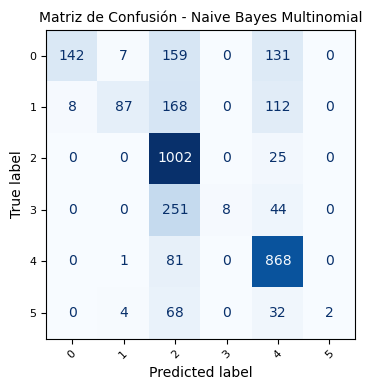

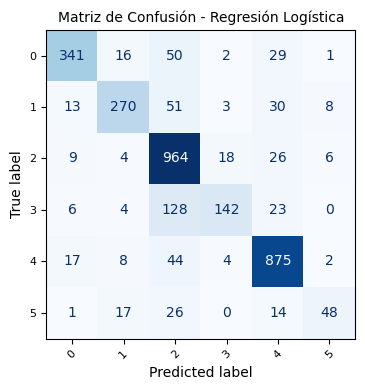

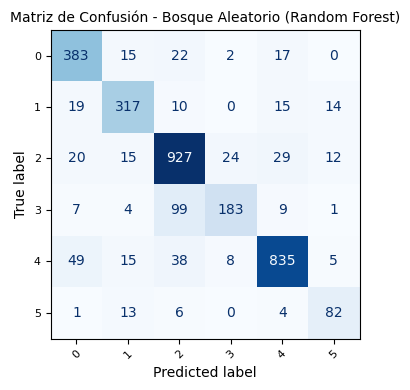

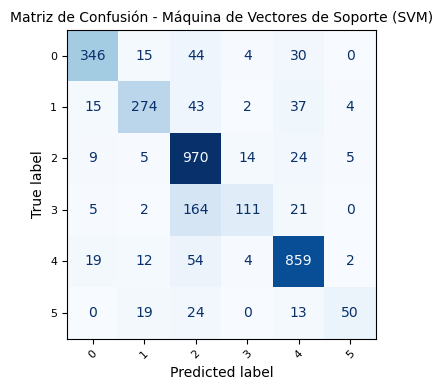

In [21]:
for nombre, modelo in classificadores.items():
    y_pred = modelo.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=modelo.classes_)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
    
    
    fig, ax = plt.subplots(figsize=(4, 4)) 
    disp.plot(ax=ax, cmap='Blues', colorbar=False)  
    plt.title(f'Matriz de Confusi√≥n - {nombre}', fontsize=10)
    plt.xticks(rotation=45, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

In [22]:
# Inicializar CountVectorizer
count_vectorizer = CountVectorizer()

# Ajustar y transformar el conjunto de entrenamiento
X_train_count = count_vectorizer.fit_transform(X_train)

# Solo transformar el conjunto de prueba
X_test_count = count_vectorizer.transform(X_test)

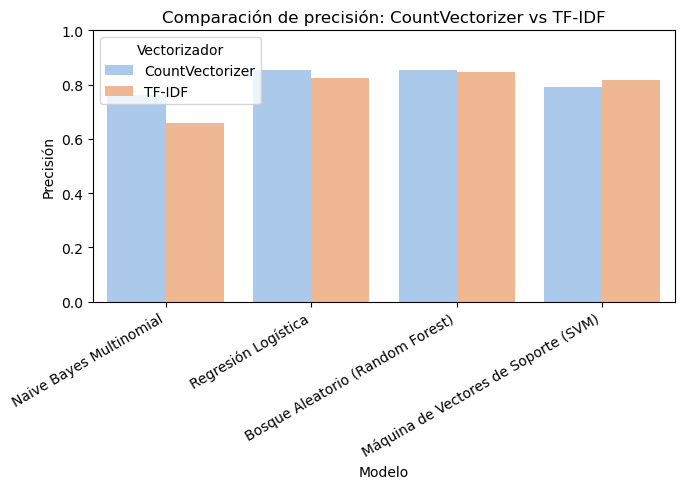

In [23]:
# Guardar resultados de ambas representaciones
resultados = []

for nombre, modelo in classificadores.items():
    # CountVectorizer
    modelo.fit(X_train_count, y_train)
    pred_count = modelo.predict(X_test_count)
    acc_count = accuracy_score(y_test, pred_count)
    
    # TF-IDF
    modelo.fit(X_train_tfidf, y_train)
    pred_tfidf = modelo.predict(X_test_tfidf)
    acc_tfidf = accuracy_score(y_test, pred_tfidf)
    
    # Guardar ambos resultados
    resultados.append((nombre, 'CountVectorizer', acc_count))
    resultados.append((nombre, 'TF-IDF', acc_tfidf))

# Crear DataFrame para graficar
df_comp = pd.DataFrame(resultados, columns=['Modelo', 'Vectorizador', 'Precisi√≥n'])

# Gr√°fico comparativo
plt.figure(figsize=(7, 5))
sns.barplot(data=df_comp, x='Modelo', y='Precisi√≥n', hue='Vectorizador', palette='pastel')
plt.title('Comparaci√≥n de precisi√≥n: CountVectorizer vs TF-IDF', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

In [24]:
# Seleccion de modelo
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

In [25]:
def predict_emotion(input_text):
    cleaned_text = limpiar_texto(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Prediccion de Emociones
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Ejemplo de uso
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]

for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Emocion :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Emocion : sadness
Label : 4
i feel strong and good overall
Emocion : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Emocion : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Emocion : joy
Label : 2
This is outrageous, how can you talk like that?
Emocion : anger
Label : 0
I feel like im all alone in this world
Emocion : sadness
Label : 4
He is really sweet and caring
Emocion : love
Label : 3
You made me very crazy
Emocion : sadness
Label : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Emocion : love
Label : 3
i am feeling grouchy
Emocion : anger
Label : 0
He hates you
Emocion : anger
Label : 0


In [26]:
def predict_emotion(input_text):
    # Limpiar y vectorizar el texto
    cleaned_text = limpiar_texto(input_text)
    vectorized_text = tfidf_vectorizer.transform([cleaned_text])

    # Realizar predicci√≥n
    predicted_label = lg.predict(vectorized_text)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    
    return predicted_emotion, predicted_label


# Lista de oraciones a evaluar
sentences = [
    "I didn't feel humiliated",
    "I feel strong and good overall",
    "I'm grabbing a minute to post I feel greedy wrong",
    "He was speechless when he found out he was accepted to this new job",
    "This is outrageous, how can you talk like that?",
    "I feel like I'm all alone in this world",
    "He is really sweet and caring",
    "You made me very crazy",
    "I am ever feeling nostalgic about the fireplace. I will know that it is still on the property",
    "I am feeling grouchy",
    "He hates you"
]

# Mostrar resultados
for idx, sentence in enumerate(sentences, 1):
    emotion, label = predict_emotion(sentence)
    print(f"{idx}. {sentence}")
    print(f"   ‚Üí Emoci√≥n: {emotion}")
    print(f"   ‚Üí Label  : {label}")
    print("-" * 60)

1. I didn't feel humiliated
   ‚Üí Emoci√≥n: sadness
   ‚Üí Label  : 4
------------------------------------------------------------
2. I feel strong and good overall
   ‚Üí Emoci√≥n: joy
   ‚Üí Label  : 2
------------------------------------------------------------
3. I'm grabbing a minute to post I feel greedy wrong
   ‚Üí Emoci√≥n: anger
   ‚Üí Label  : 0
------------------------------------------------------------
4. He was speechless when he found out he was accepted to this new job
   ‚Üí Emoci√≥n: joy
   ‚Üí Label  : 2
------------------------------------------------------------
5. This is outrageous, how can you talk like that?
   ‚Üí Emoci√≥n: anger
   ‚Üí Label  : 0
------------------------------------------------------------
6. I feel like I'm all alone in this world
   ‚Üí Emoci√≥n: sadness
   ‚Üí Label  : 4
------------------------------------------------------------
7. He is really sweet and caring
   ‚Üí Emoci√≥n: love
   ‚Üí Label  : 3
-----------------------------------

In [27]:
#Guardar modelo
pickle.dump(lg,open("logistic_regresion.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))

#### Uso de red Neuronal

##### Limpieza, Codificaci√≥n y Relleno de Texto

In [28]:
# Limpienza
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(df, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(df["Emotion"])

#### Red Neuronal

In [29]:
# Definici√≥n del modelo
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.3))

# LSTM bidireccional para capturar contexto en ambas direcciones
model.add(Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001))))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa oculta
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(6, activation='softmax'))

# Compilaci√≥n
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding (Embedding)           ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ ?                      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional (Bidirectional)   ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ ?                      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ ?                      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 634s 2s/step - accuracy: 0.3223 - loss: 2.3447
Epoch 2/10
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 509s 2s/step - accuracy: 0.7939 - loss: 0.8583
Epoch 3/10
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 430s 2s/step - accuracy: 0.8644 - loss: 0.5891
Epoch 4/10
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 425s 2s/step - accuracy: 0.9012 - loss: 0.4483
Epoch 5/10
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 450s 2s/step - accuracy: 0.9116 - loss: 0.3778
Epoch 6/10
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 424s 2s/step - accuracy: 0.9183 - loss: 0.3356
Epoch 7/10
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 434s 2s/step - accuracy: 0.9333 - loss: 0.2868
Epoch 8/10
250/250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 435s 2s/step - accuracy: 0.9334

In [31]:
history = model.fit(x_train,y_train,epochs=6,batch_size=64,validation_split=0.2, verbose=1,callbacks=[callback])

Epoch 1/6
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 376s 2s/step - accuracy: 0.9520 - loss: 0.1958 - val_accuracy: 0.8972 - val_loss: 0.3412
Epoch 2/6
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 348s 2s/step - accuracy: 0.9605 - loss: 0.1668 - val_accuracy: 0.8578 - val_loss: 0.5334
Epoch 3/6
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 350s 2s/step - accuracy: 0.9619 - loss: 0.1576 - val_accuracy: 0.9316 - val_loss: 0.2370
Epoch 4/6
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363s 2s/step - accuracy: 0.9679 - loss: 0.1421 - val_accuracy: 0.9250 - val_loss: 0.2751
Epoch 5/6
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 359s 2s/step - accuracy: 0.9680 - loss: 0.1359 - val_accuracy: 0.9069 - val_loss: 0.3136


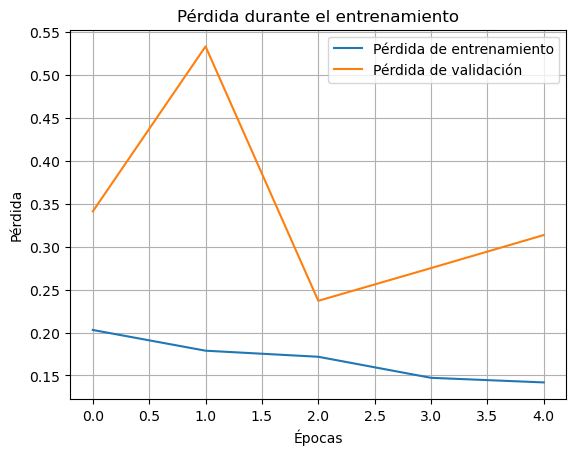

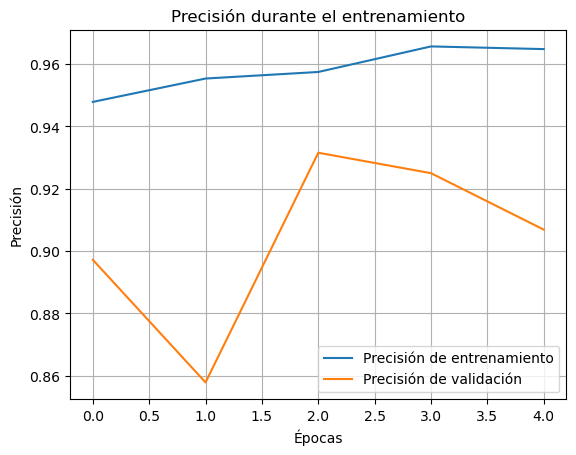

In [32]:
# Graficar p√©rdida (loss)
plt.plot(history.history['loss'], label='P√©rdida de entrenamiento')
plt.plot(history.history['val_loss'], label='P√©rdida de validaci√≥n')
plt.title('P√©rdida durante el entrenamiento')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.legend()
plt.grid(True)
plt.show()

# Graficar precisi√≥n (accuracy)
plt.plot(history.history['accuracy'], label='Precisi√≥n de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisi√≥n de validaci√≥n')
plt.title('Precisi√≥n durante el entrenamiento')
plt.xlabel('√âpocas')
plt.ylabel('Precisi√≥n')
plt.legend()
plt.grid(True)
plt.show()

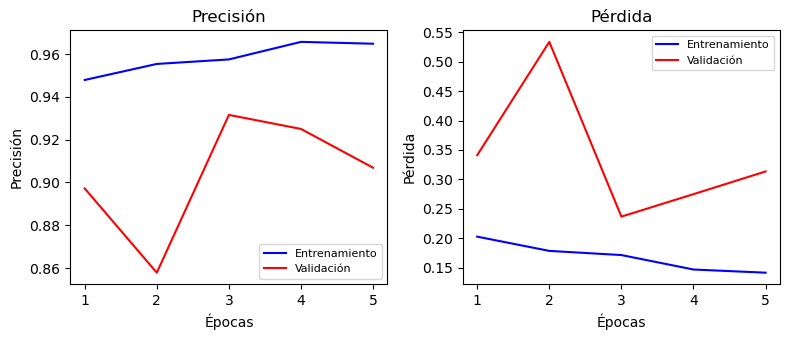

In [33]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 3.5))

    # Precisi√≥n
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Entrenamiento')
    plt.plot(epochs, val_acc, 'r', label='Validaci√≥n')
    plt.title('Precisi√≥n')
    plt.xlabel('√âpocas')
    plt.ylabel('Precisi√≥n')
    plt.legend(fontsize=8)

    # P√©rdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Validaci√≥n')
    plt.title('P√©rdida')
    plt.xlabel('√âpocas')
    plt.ylabel('P√©rdida')
    plt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

# Llamar a la funci√≥n
plot_training_history(history)

#### Prediccion

In [34]:
# Limpieza y preparaci√≥n de texto
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# Frases para probar
sentences = [
    "i feel strong and good overall",
    "im grabbing a minute to post i feel greedy wrong",
    "He was speechles when he found out he was accepted to this new job",
    "This is outrageous, how can you talk like that?",
    "I feel like im all alone in this world",
    "He is really sweet and caring",
    "You made me very crazy",
    "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
    "i am feeling grouchy",
    "He hates you"
]

# Predicci√≥n
for sentence in sentences:
    print(sentence)
    cleaned = sentence_cleaning(sentence)
    prediction = model.predict(cleaned)
    predicted_class = np.argmax(prediction, axis=1)
    result = lb.inverse_transform(predicted_class)[0]
    proba = np.max(prediction)
    print(f"{result} : {proba:.4f}\n")

i feel strong and good overall
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 958ms/step
joy : 0.9972

im grabbing a minute to post i feel greedy wrong
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 124ms/step
anger : 0.9997

He was speechles when he found out he was accepted to this new job
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 144ms/step
joy : 0.5237

This is outrageous, how can you talk like that?
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 118ms/step
anger : 0.9995

I feel like im all alone in this world
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 126ms/step
sadness : 0.9786

He is really sweet and caring
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 112ms/step
love : 0.8949

You made me very crazy
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 132ms/step
anger : 0.8405

i am ever feeling nostalgic about the fireplace i w

#### Guardar Modelo

In [35]:
model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

